# Prediction of Titanic Survivals

The aim of the notebook is to build a machine learning model for prediction the chances of survival based on Titanic dataset.

Data covers demographic information such as sex, age, number of family members onboard as well as information about ticket fare, class, cabin and embarking port.

<img src="https://insidearabia.com/wp-content/uploads/2019/04/The-Titanic-My-Grandfather’s-Unsinkable-Memories-3-e1556531238178-980x640.jpg" width="400" height="200">

#### Importing libraries

In [40]:
import pandas as pd
import numpy as np

from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer

#### Loading data

In [62]:
train = pd.read_csv('./train.csv', index_col=0)
test = pd.read_csv('./test.csv', index_col=0)
train.shape, test.shape

((891, 11), (418, 10))

In [63]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Checking missing data

In [65]:
missing_val_count_by_column_train = (train.isnull().sum())
missing_val_count_by_column_train[missing_val_count_by_column_train>0]

Age         177
Cabin       687
Embarked      2
dtype: int64

In [66]:
missing_val_count_by_column_test = (test.isnull().sum())
missing_val_count_by_column_test[missing_val_count_by_column_test>0]

Age       86
Fare       1
Cabin    327
dtype: int64

Cabin is variable with over 50% of nulls, so I decide to remove it from the analysis.

In [67]:
train.drop('Cabin', inplace=True, axis=1)
test.drop('Cabin', inplace=True, axis=1)

#### Exploratory data analysis

In [86]:
train.groupby(['Pclass','Survived'])['Name'].count().unstack()

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


In [87]:
train.groupby(['Sex','Survived'])['Name'].count().unstack()

Survived,0,1
Sex,,
female,81,233
male,468,109


In [88]:
train.groupby(['Embarked','Survived'])['Name'].count().unstack()

Survived,0,1
Embarked,,
C,75,93
Q,47,30
S,427,217


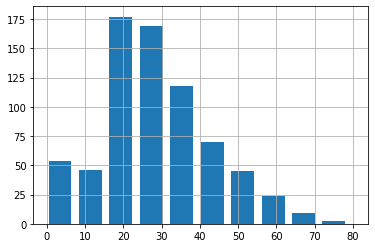

In [73]:
import matplotlib.pyplot as plt
train["Age"].hist(width=6)

#### Imputing missing data

Age is second filed with the higest number of null values. I decided to impute nans with mean age taking into consideration sex, number of siblings and number of paretns. However, this approach leaves a few nulls, so then mean along sex is imputed.

In [89]:
train['Age'] = train['Age'].fillna(train.groupby(['Sex', 'SibSp', 'Parch'])['Age'].transform('mean'))
train['Age'] = train['Age'].fillna(train.groupby(['Sex'])['Age'].transform('mean'))

test['Age'] = test['Age'].fillna(test.groupby(['Sex', 'SibSp', 'Parch'])['Age'].transform('mean'))
test['Age'] = test['Age'].fillna(test.groupby(['Sex'])['Age'].transform('mean'))

Imputing most frequent embarking port.

In [90]:
train['Embarked'] = train.Embarked.fillna(train.Embarked.value_counts().index[0])

#### Feature engineering

Below I create a few metrics which might be meaningful in the analysis: ticket fare per person, number of passenger on a single ticket, string concatenation of sex and age

In [93]:
train['Fare_per_person'] = train.Fare / train.groupby('Ticket')['Pclass'].transform('count')
train['Survived_per_ticket'] = train.groupby('Ticket')['Survived'].transform('sum')
# train['People_per_ticket'] = train.groupby('Ticket')['Name'].transform('count')
train['age_x_sex'] = [str(round(train.Age.iloc[i], -1)) + train.Sex.iloc[i] for i in range(train.shape[0])]

In [94]:
test['Fare_per_person'] = test.Fare / test.groupby('Ticket')['Pclass'].transform('count')
test['Survived_per_ticket'] = test.groupby('Ticket')['Sex'].transform('count')
test['age_x_sex'] = [str(round(test.Age.iloc[i], -1)) + test.Sex.iloc[i] for i in range(test.shape[0])]
# test['People_per_ticket'] = test.groupby('Ticket')['Name'].transform('count')

In [95]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Fare_per_person,Survived_per_ticket,age_x_sex
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,7.2500,0,20.0male
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,71.2833,1,40.0female
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,7.9250,1,30.0female
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,26.5500,1,40.0female
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,8.0500,0,40.0male


#### Data modelling

First, I caclulate the model score based on cross validation on train score. Then I'm applying the model to train data to get my predictions.

In [34]:
preprocess = make_column_transformer(
    ( SimpleImputer(), ['Age',  'Fare', 'SibSp', 'Parch', 'Survived_per_ticket']),
#     ( SimpleImputer(strategy='most_frequent'), ['age_x_sex']),
    ( make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(sparse=False)),
     [ 'Pclass', 'Sex', 'Embarked', 'age_x_sex']),
)

TypeError: Last step of Pipeline should implement fit or be the string 'passthrough'. '['Age', 'Fare', 'SibSp', 'Parch', 'Survived_per_ticket']' (type <class 'list'>) doesn't

In [33]:
clf = Pipeline(steps=[('pre', preprocess), ('NB', GaussianNB())])
cv = cross_val_score(clf, train, train.Survived, cv=5, scoring='accuracy')
cv

ValueError: Found unknown categories ['80.0male'] in column 3 during transform

In [28]:
cross_val_score(SVC(gamma='auto', C=100), train_1, train.Survived, cv=5, scoring='accuracy')

array([0.8547486 , 0.8603352 , 0.85955056, 0.88764045, 0.89265537])

In [59]:
cross_val_score(RandomForestClassifier(n_estimators=100, max_depth=3), train_1, train.Survived, cv=5, scoring='accuracy')

array([0.89385475, 0.89944134, 0.89325843, 0.85393258, 0.90960452])

In [52]:
cross_val_score(RandomForestClassifier(n_estimators=1000, ), train_1, train.Survived, cv=5, scoring='accuracy')

array([0.97206704, 0.93296089, 0.97191011, 0.93258427, 0.98305085])

In [32]:
cross_val_score(SVC(gamma='auto', C=500), train_1, train.Survived, cv=5, scoring='accuracy')

array([0.84357542, 0.8603352 , 0.87640449, 0.84831461, 0.88700565])

In [23]:
cross_val_score(GaussianNB(), train_1, train.Survived, cv=5, scoring='accuracy')

array([0.81564246, 0.81564246, 0.80337079, 0.79775281, 0.84745763])

In [9]:
clf = Pipeline(steps=[('pre', preprocess), ('NB', SVC(C=10, gamma='auto'))])
cv = cross_val_score(clf, train.iloc[:, 1:], train.Survived, cv=5, scoring='accuracy')
cv, cv.mean()

ValueError: Found unknown categories ['80.0male'] in column 3 during transform

In [31]:
clf.fit(train.iloc[:, 1:], train.Survived)
clf.predict(test)

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,

In [60]:
train_1 = preprocess.fit_transform(train)
test_1 = preprocess.fit_transform(test)

nb = RandomForestClassifier(n_estimators=100, max_depth=3)
nb.fit(train_1, train.Survived)
preds = pd.DataFrame(nb.predict(test_1), index=test.index, columns=['Survived'])

In [61]:
preds.to_csv('./titanic2.csv')

In [32]:
preds['S2'] = clf.predict(test)

In [33]:
preds[preds.Survived != preds.S2]

,Survived,S2
PassengerId,,
